**Crime Data Analysis**

Installing Spark

In [ ]:
# Download and Extract Spark
!wget -q https://dlcdn.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz

In [ ]:
# Set Up Environment Variables
import os
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]='/content/spark-3.5.1-bin-hadoop3'

In [ ]:
# Install libraries
!pip install -q findspark
!pip install -q pyspark

In [ ]:
# Initialize Findspark
import findspark
findspark.init()
findspark.find()

'/content/spark-3.5.1-bin-hadoop3'

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, desc, when

In [ ]:
# Create Spark Context
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("CrimeDataAnalysis").getOrCreate()
sc = spark.sparkContext

In [ ]:
# Load the dataset
df = spark.read.csv('/content/drive/My Drive/hiscrimdata.csv', header=True, inferSchema=True)

Understanding Dataset


In [ ]:
df.printSchema()
df.show()

root
 |-- TYPE: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- MINUTE: integer (nullable = true)
 |-- HUNDRED_BLOCK: string (nullable = true)
 |-- NEIGHBOURHOOD: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)

+------------------+----+-----+---+----+------+------------------+--------------------+-----------+------------+
|              TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|     HUNDRED_BLOCK|       NEIGHBOURHOOD|          X|           Y|
+------------------+----+-----+---+----+------+------------------+--------------------+-----------+------------+
|Theft from Vehicle|2006|    3|  4|  20|    30|DAVIE ST / HOWE ST|Central Business ...|490748.5904|5458346.3184|
|Theft from Vehicle|2006|    3|  5|  11|    30|DAVIE ST / HOWE ST|Central Business ...|490748.5904|5458346.3184|
|Theft from Vehicle|2006|    4| 16|   0|     1|DAV

In [ ]:
# Summary statistics of numerical columns
df.describe().show()

+-------+--------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+---------------+------------------+------------------+
|summary|                TYPE|              YEAR|            MONTH|               DAY|              HOUR|            MINUTE|       HUNDRED_BLOCK|  NEIGHBOURHOOD|                 X|                 Y|
+-------+--------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+---------------+------------------+------------------+
|  count|              793916|            793916|           793916|            793916|            793916|            793916|              793904|         793783|            793843|            793843|
|   mean|                NULL|2011.1894998967146|6.494100131500058|15.394094589352022|12.397744849581064|15.711429168828944|                NULL|           NULL| 450191.8353856909| 4991158.124680623|


In [ ]:
# Checking for missing values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+----+-----+---+----+------+-------------+-------------+---+---+
|TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|HUNDRED_BLOCK|NEIGHBOURHOOD|  X|  Y|
+----+----+-----+---+----+------+-------------+-------------+---+---+
|   0|   0|    0|  0|   0|     0|           12|          133| 73| 73|
+----+----+-----+---+----+------+-------------+-------------+---+---+



In [ ]:
# Fill missing values with 0
df = df.na.fill(0)

# Null values in HUNDRED_BLOCK and NEIGHBOURHOOD is to protect privacy.
# Impute missing values in NEIGHBOURHOOD and HUNDRED_BLOCK with "Unknown"
df = df.na.fill({"NEIGHBOURHOOD": "Unknown", "HUNDRED_BLOCK": "Unknown"})

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+----+-----+---+----+------+-------------+-------------+---+---+
|TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|HUNDRED_BLOCK|NEIGHBOURHOOD|  X|  Y|
+----+----+-----+---+----+------+-------------+-------------+---+---+
|   0|   0|    0|  0|   0|     0|            0|            0|  0|  0|
+----+----+-----+---+----+------+-------------+-------------+---+---+



In [ ]:
# When HUNDRED_BLOCK is null, HOUR, MINUTE, X and Y are 0, this could lead to inconsistencies in analysis.
# Filter out incomplete records where HUNDRED_BLOCK is null and HOUR, MINUTE, X, and Y are 0
df = df.filter(~((col('HUNDRED_BLOCK').isNull()) &
                          (col('HOUR') == 0) &
                          (col('MINUTE') == 0) &
                          (col('X') == 0) &
                          (col('Y') == 0)))

# Verify the filtered data
df.show(5)


+------------------+----+-----+---+----+------+------------------+--------------------+-----------+------------+
|              TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|     HUNDRED_BLOCK|       NEIGHBOURHOOD|          X|           Y|
+------------------+----+-----+---+----+------+------------------+--------------------+-----------+------------+
|Theft from Vehicle|2006|    3|  4|  20|    30|DAVIE ST / HOWE ST|Central Business ...|490748.5904|5458346.3184|
|Theft from Vehicle|2006|    3|  5|  11|    30|DAVIE ST / HOWE ST|Central Business ...|490748.5904|5458346.3184|
|Theft from Vehicle|2006|    4| 16|   0|     1|DAVIE ST / HOWE ST|Central Business ...|490748.5904|5458346.3184|
|Theft from Vehicle|2006|    6| 11|  17|    45|DAVIE ST / HOWE ST|Central Business ...|490748.5904|5458346.3184|
|Theft from Vehicle|2006|    8|  5|  20|     0|DAVIE ST / HOWE ST|Central Business ...|490748.5904|5458346.3184|
+------------------+----+-----+---+----+------+------------------+--------------------+---------

In [ ]:
# Detecting and Removing Outliers
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.functions import expr, col

# Select numeric columns for outlier detection
numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType))]

# Calculate Q1 and Q3 for numerical columns
quantiles = df.approxQuantile(numeric_columns, [0.25, 0.75], 0.01)
q1_q3 = {col: (quantiles[i][0], quantiles[i][1]) for i, col in enumerate(numeric_columns)}

# Calculate IQR and define lower and upper bounds
iqr_bounds = {col: (q1 - 1.5 * (q3 - q1), q3 + 1.5 * (q3 - q1)) for col, (q1, q3) in q1_q3.items()}

# Filter out outliers based on IQR
df_no_outliers_iqr = df
for col_name, (lower, upper) in iqr_bounds.items():
    df = df_no_outliers_iqr.filter((col(col_name) >= lower) & (col(col_name) <= upper))

# Show summary statistics for comparison
df.describe().show()


+-------+--------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+---------------+-----------------+------------------+
|summary|                TYPE|              YEAR|             MONTH|               DAY|             HOUR|            MINUTE|       HUNDRED_BLOCK|  NEIGHBOURHOOD|                X|                 Y|
+-------+--------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+---------------+-----------------+------------------+
|  count|              726095|            726095|            726095|            726095|           726095|            726095|              726095|         726095|           726095|            726095|
|   mean|                NULL|2011.1749109964949| 6.497589158443454|15.386515538600321|13.55428697346766|17.176402536858124|                NULL|           NULL|492194.9604377981| 5456833.542690475|
| std

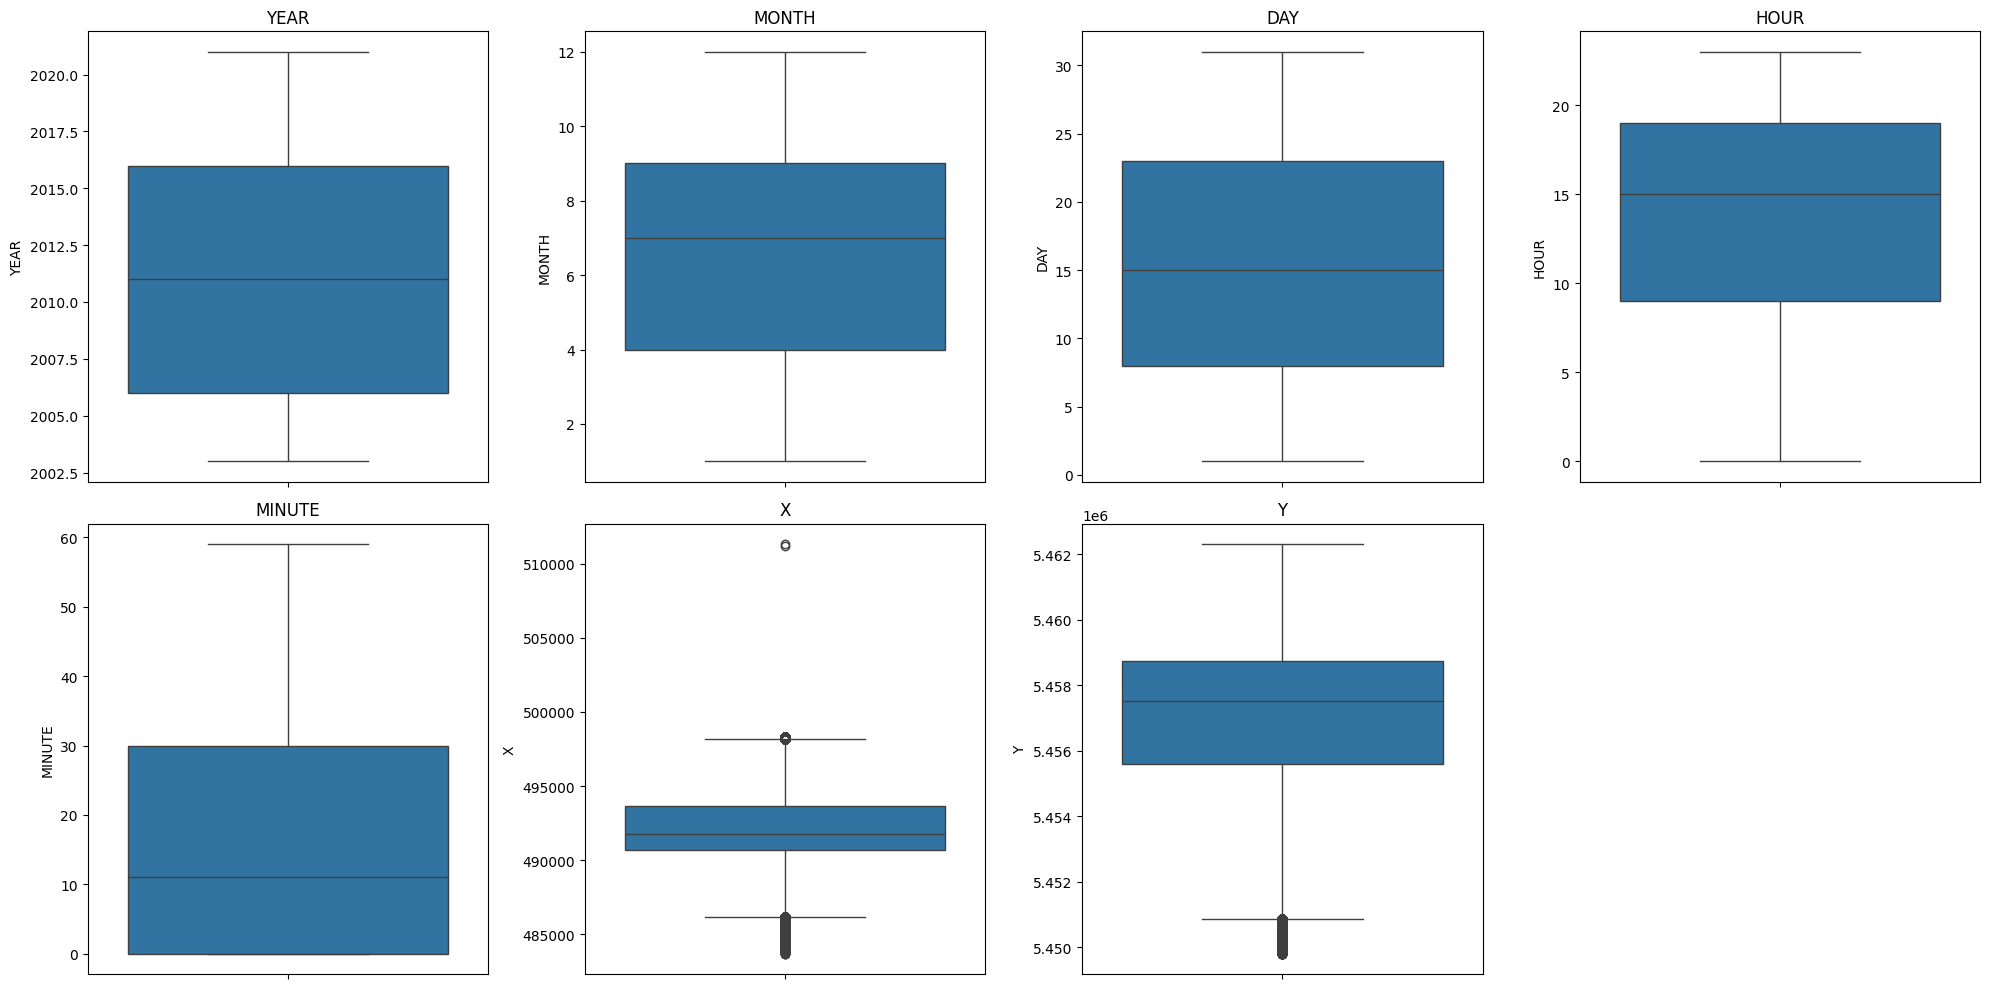

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
df_pd = df.select(numeric_columns).toPandas()

# Plotting individual box plots for each column after removing outliers
plt.figure(figsize=(20, 10))

for i, col in enumerate(numeric_columns):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(data=df_pd[col])
    plt.title(col)

plt.tight_layout()
plt.show()

EXPLORATORY DATA ANALYSIS

In [ ]:
# Count of each crime type
crime_types = df.groupBy('TYPE').count().orderBy('count', ascending=False)
crime_types.show()

+--------------------+------+
|                TYPE| count|
+--------------------+------+
|  Theft from Vehicle|224662|
|         Other Theft|192655|
|            Mischief| 92912|
|Break and Enter R...| 69367|
|Break and Enter C...| 43067|
|    Theft of Vehicle| 42794|
|    Theft of Bicycle| 33763|
|Vehicle Collision...| 26569|
|Vehicle Collision...|   306|
+--------------------+------+



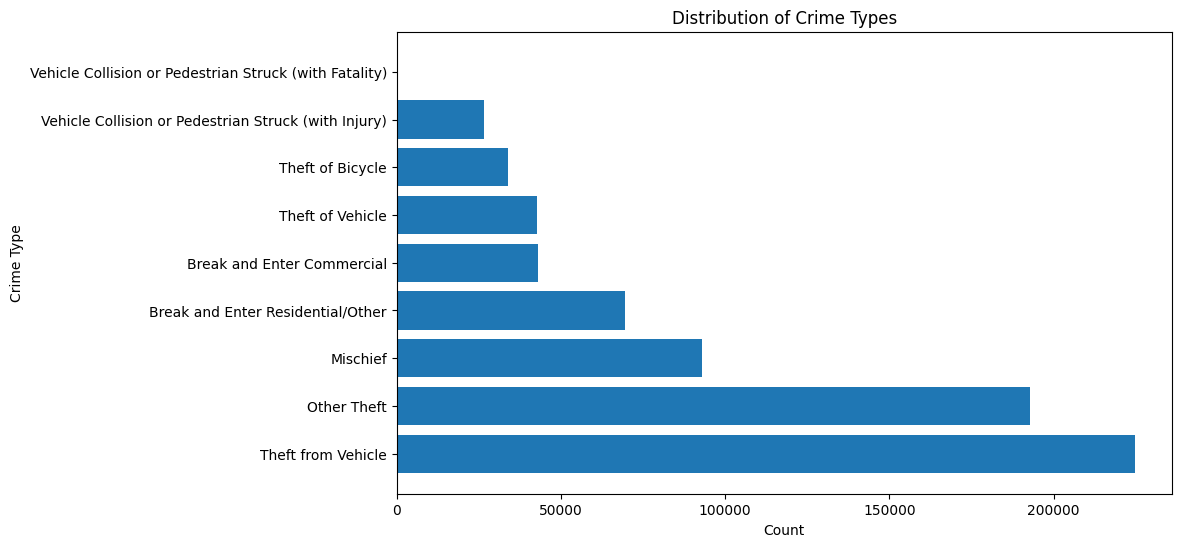

In [ ]:
import matplotlib.pyplot as plt

# Converting Spark DataFrame to Pandas DataFrame for visualization
crime_types_pd = crime_types.toPandas()

# Plotting the distribution of crime types
plt.figure(figsize=(10, 6))
plt.barh(crime_types_pd['TYPE'], crime_types_pd['count'])
plt.xlabel('Count')
plt.ylabel('Crime Type')
plt.title('Distribution of Crime Types')
plt.show()

In [ ]:
# Identify top 5 crime types
top_crimes = crime_types_pd.head(5)['TYPE'].tolist()
print("Top 5 Crime Types:", top_crimes)

Top 5 Crime Types: ['Theft from Vehicle', 'Other Theft', 'Mischief', 'Break and Enter Residential/Other', 'Break and Enter Commercial']


In [ ]:
from pyspark.sql import functions as F

# Filter data for top crime types
top_crimes_data = df.filter(F.col('TYPE').isin(top_crimes))

# Aggregate crime count by neighborhood and type
topcrimes_byneighbourhood = top_crimes_data.groupBy('NEIGHBOURHOOD', 'TYPE').count().orderBy('count', ascending=False)
topcrimes_byneighbourhood.show()

+--------------------+--------------------+-----+
|       NEIGHBOURHOOD|                TYPE|count|
+--------------------+--------------------+-----+
|Central Business ...|         Other Theft|67861|
|Central Business ...|  Theft from Vehicle|65476|
|Central Business ...|            Mischief|23844|
|            West End|  Theft from Vehicle|21725|
|            West End|         Other Theft|20271|
|            Fairview|  Theft from Vehicle|14600|
|            Fairview|         Other Theft|12854|
|      Mount Pleasant|  Theft from Vehicle|12489|
|      Mount Pleasant|         Other Theft|12406|
|          Strathcona|  Theft from Vehicle|12202|
|Central Business ...|Break and Enter C...|12010|
|          Strathcona|         Other Theft|11949|
|           Kitsilano|  Theft from Vehicle|11286|
| Renfrew-Collingwood|  Theft from Vehicle|10809|
| Renfrew-Collingwood|         Other Theft|10168|
|  Grandview-Woodland|  Theft from Vehicle| 9632|
|Kensington-Cedar ...|  Theft from Vehicle| 9506|


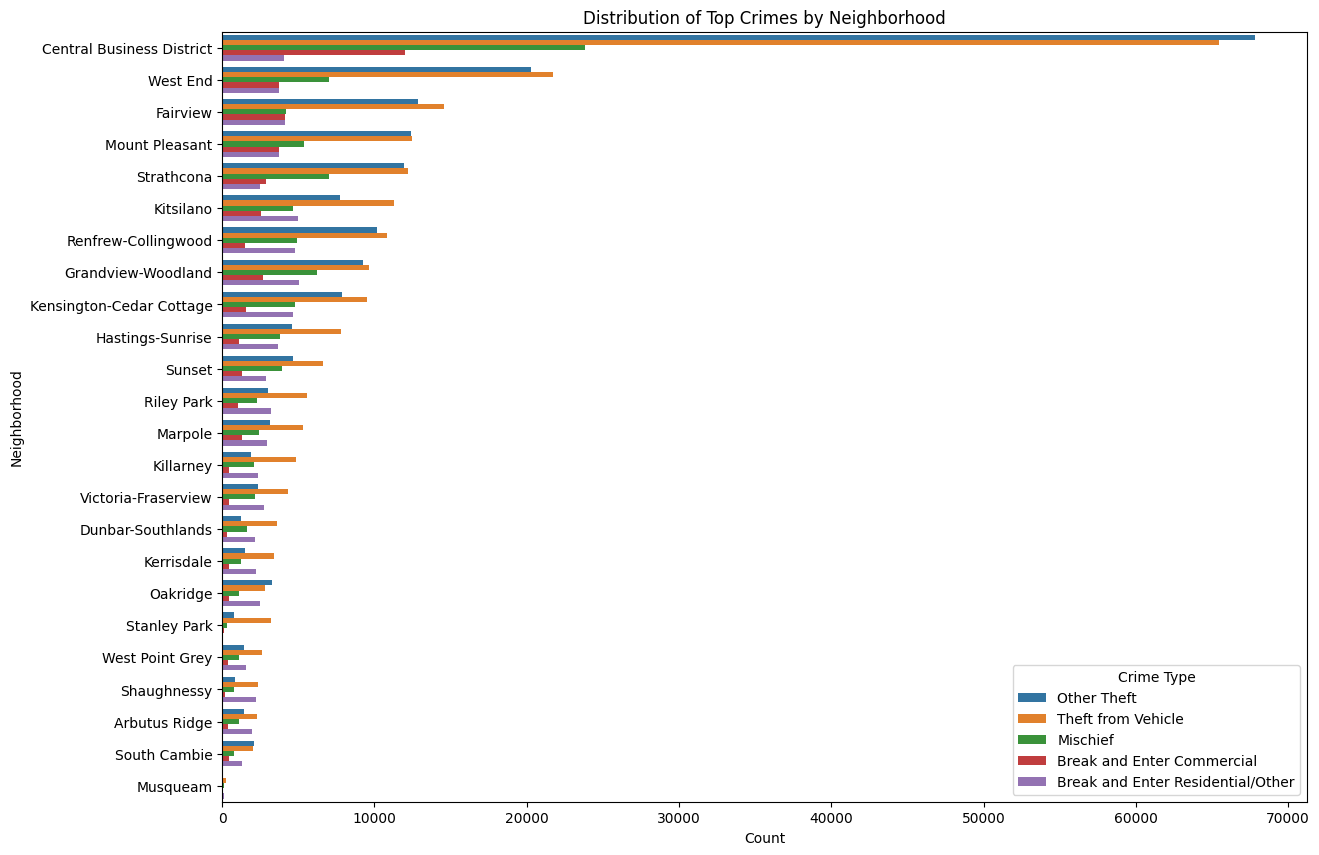

In [ ]:
# Convert to Pandas DataFrame for visualization
topcrimes_byneighbourhood_pd = topcrimes_byneighbourhood.toPandas()

# Plotting the distribution of top crimes by neighborhood
plt.figure(figsize=(14, 10))
sns.barplot(data=topcrimes_byneighbourhood_pd, x='count', y='NEIGHBOURHOOD', hue='TYPE')
plt.xlabel('Count')
plt.ylabel('Neighborhood')
plt.title('Distribution of Top Crimes by Neighborhood')
plt.legend(title='Crime Type')
plt.show()

+----+-----+
|YEAR|count|
+----+-----+
|2003|55275|
|2004|54290|
|2005|49642|
|2006|45288|
|2007|39967|
|2008|37497|
|2009|34078|
|2010|31893|
|2011|30537|
|2012|31768|
|2013|32185|
|2014|36103|
|2015|37042|
|2016|40942|
|2017|40050|
|2018|41280|
|2019|44767|
|2020|33699|
|2021| 9792|
+----+-----+



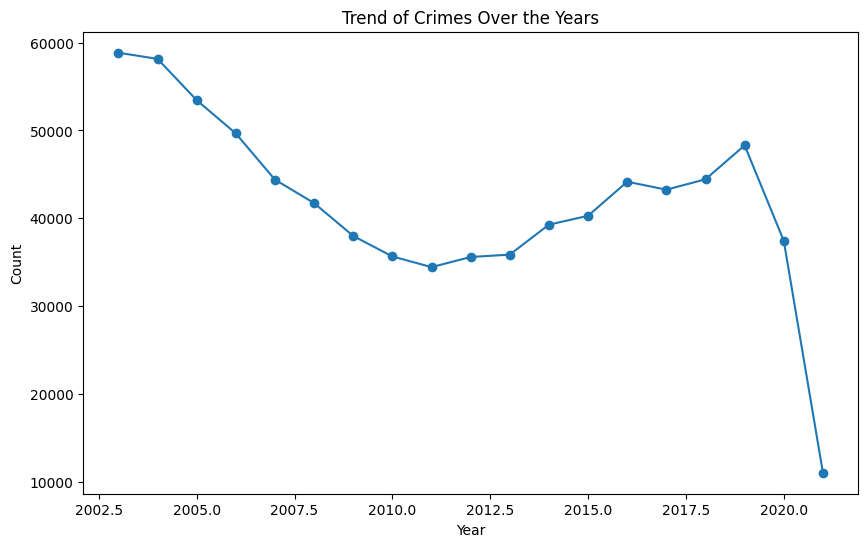

In [ ]:
# Count of crimes per year
crime_per_year = df.groupBy('YEAR').count().orderBy('YEAR')
crime_per_year.show()

# Plotting the trend of crimes over the years
plt.figure(figsize=(10, 6))
plt.plot(crime_per_year_pd['YEAR'], crime_per_year_pd['count'], marker='o')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Trend of Crimes Over the Years')
plt.show()

+----+-----+-----+
|YEAR|MONTH|count|
+----+-----+-----+
|2003|    1| 4697|
|2003|    2| 3969|
|2003|    3| 4346|
|2003|    4| 4652|
|2003|    5| 5142|
|2003|    6| 5024|
|2003|    7| 4640|
|2003|    8| 4797|
|2003|    9| 4421|
|2003|   10| 4912|
|2003|   11| 4381|
|2003|   12| 4294|
|2004|    1| 4153|
|2004|    2| 3998|
|2004|    3| 4524|
|2004|    4| 4490|
|2004|    5| 4476|
|2004|    6| 4242|
|2004|    7| 4470|
|2004|    8| 4879|
+----+-----+-----+
only showing top 20 rows



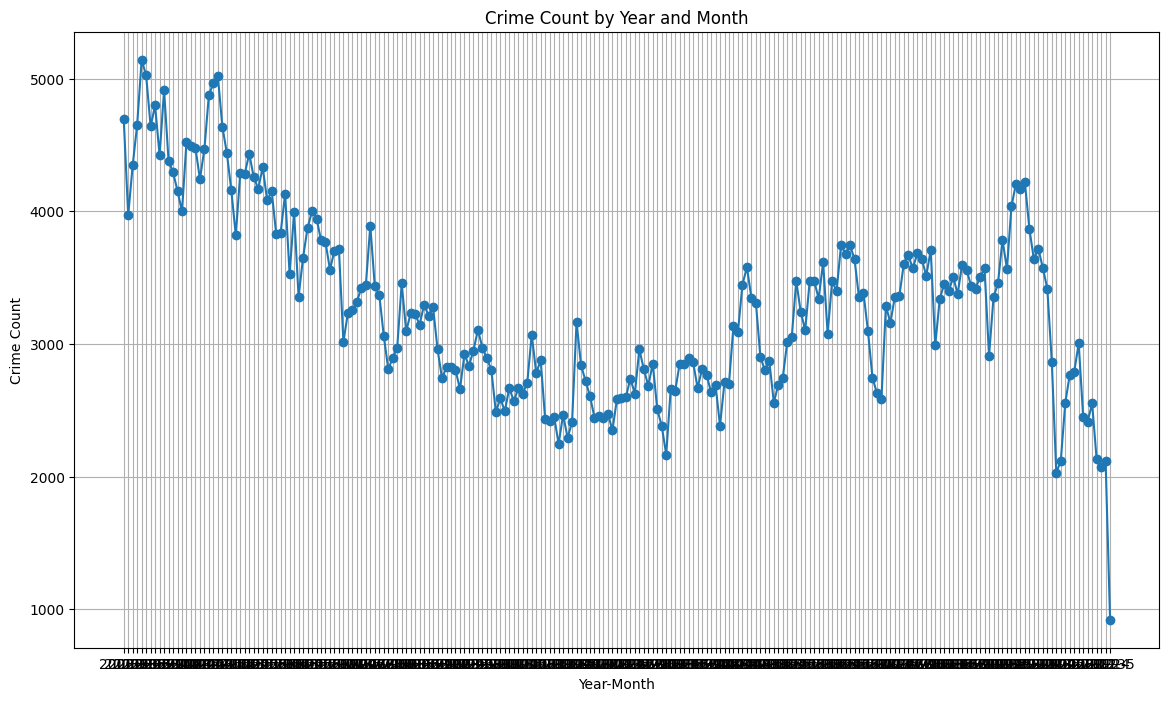

In [ ]:
# Aggregate crime count by year and month
crime_per_month_year = df.groupBy('YEAR', 'MONTH').count().orderBy('YEAR', 'MONTH')
crime_per_month_year.show()

# Convert to Pandas DataFrame for visualization
crime_per_month_year_pd = crime_per_month_year.toPandas()

# Create a column for the year-month combination
crime_per_month_year_pd['YEAR_MONTH'] = crime_per_month_year_pd['YEAR'].astype(str) + '-' + crime_per_month_year_pd['MONTH'].astype(str)

# Plotting the crime count by year and month
plt.figure(figsize=(14, 8))
plt.plot(crime_per_month_year_pd['YEAR_MONTH'], crime_per_month_year_pd['count'], marker='o')
plt.xlabel('Year-Month')
plt.ylabel('Crime Count')
plt.title('Crime Count by Year and Month')
plt.grid(True)
plt.show()

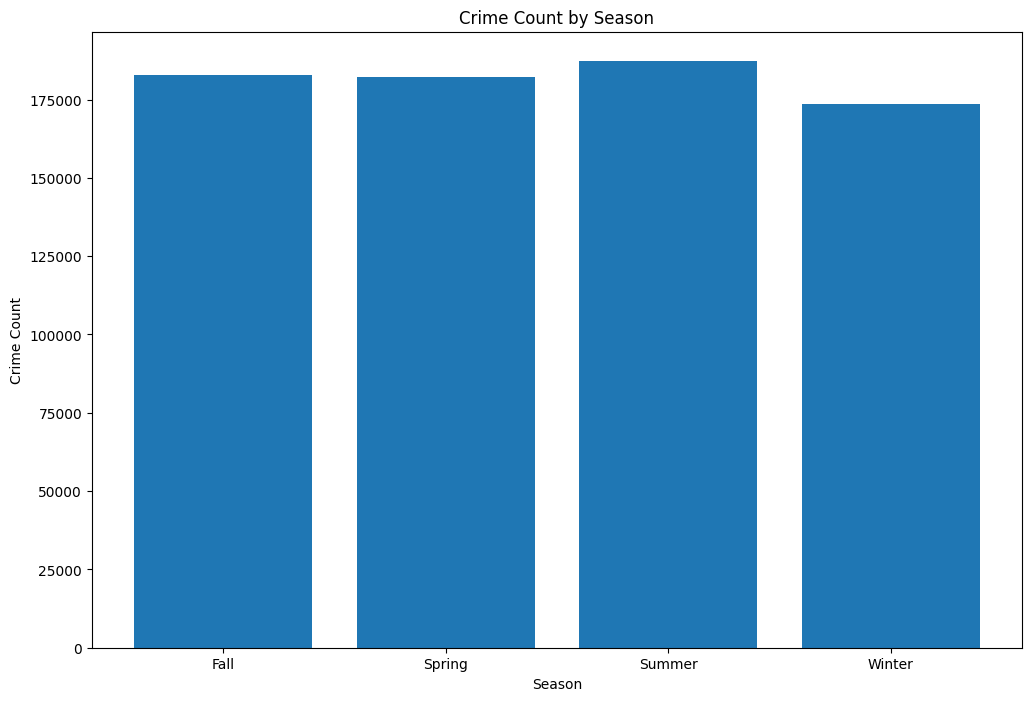

In [ ]:
# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Aggregate crime count by month
crime_per_month = df.groupBy('MONTH').count().orderBy('MONTH')
crime_per_month_pd = crime_per_month.toPandas()

# Map each month to its season
crime_per_month_pd['Season'] = crime_per_month_pd['MONTH'].apply(get_season)

# Group by season and sum the counts
crime_per_season_pd = crime_per_month_pd.groupby('Season').sum().reset_index()

# Plotting the crime count by season
plt.figure(figsize=(12, 8))
plt.bar(crime_per_season_pd['Season'], crime_per_season_pd['count'])
plt.xlabel('Season')
plt.ylabel('Crime Count')
plt.title('Crime Count by Season')
plt.show()


+--------------------+------+
|       NEIGHBOURHOOD| count|
+--------------------+------+
|Central Business ...|190692|
|            West End| 64524|
|            Fairview| 47869|
|      Mount Pleasant| 46284|
|          Strathcona| 41592|
|  Grandview-Woodland| 39667|
|           Kitsilano| 38250|
| Renfrew-Collingwood| 37846|
|Kensington-Cedar ...| 34606|
|    Hastings-Sunrise| 25803|
|              Sunset| 23748|
|             Marpole| 18433|
|          Riley Park| 18170|
| Victoria-Fraserview| 14657|
|           Killarney| 13987|
|            Oakridge| 11670|
|   Dunbar-Southlands| 10244|
|          Kerrisdale| 10213|
|     West Point Grey|  8465|
|       Arbutus Ridge|  8305|
+--------------------+------+
only showing top 20 rows



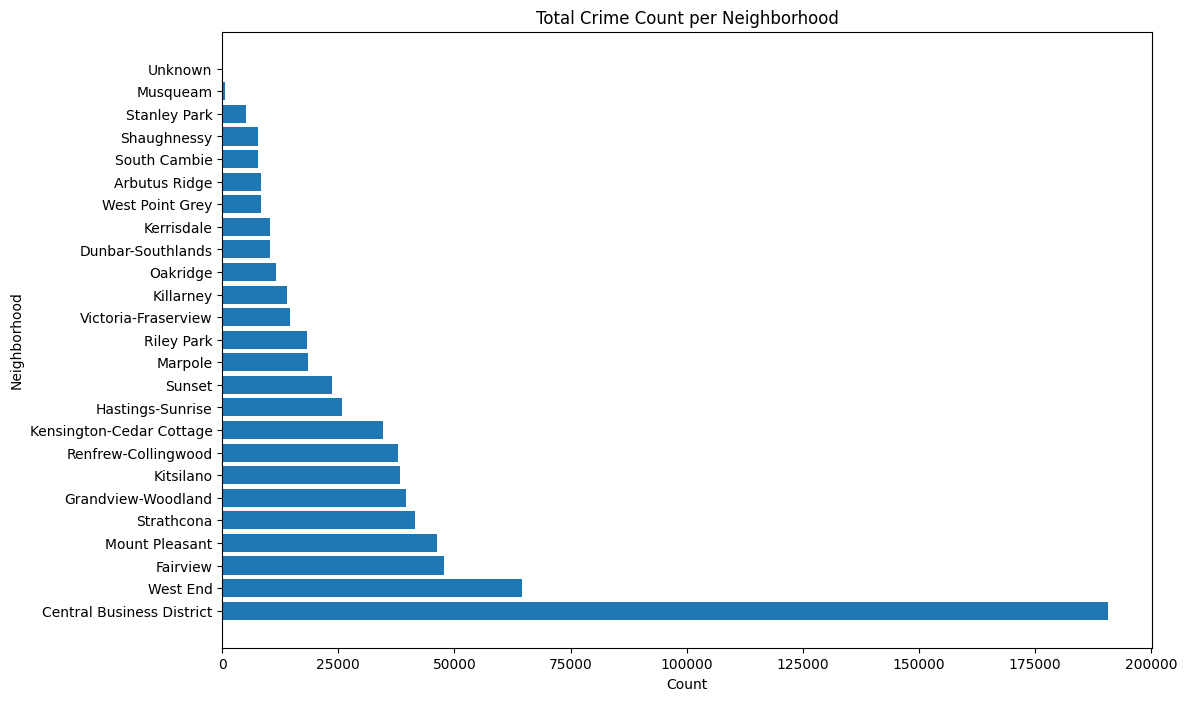

In [ ]:
# Count of crimes per neighborhood
crime_per_neighbourhood = df.groupBy('NEIGHBOURHOOD').count().orderBy('count', ascending=False)
crime_per_neighbourhood.show()

# Convert to Pandas DataFrame for visualization
crime_per_neighbourhood_pd = crime_per_neighbourhood.toPandas()

# Plotting the total crime count per neighbourhood
plt.figure(figsize=(12, 8))
plt.barh(crime_per_neighbourhood_pd['NEIGHBOURHOOD'], crime_per_neighbourhood_pd['count'])
plt.xlabel('Count')
plt.ylabel('Neighborhood')
plt.title('Total Crime Count per Neighborhood')
plt.show()

In [ ]:
# Aggregate crime count per year for each neighborhood
crime_trend_neighbourhood = df.groupBy('NEIGHBOURHOOD', 'YEAR').count().orderBy('NEIGHBOURHOOD', 'YEAR')
crime_trend_neighbourhood.show()


+--------------------+----+-----+
|       NEIGHBOURHOOD|YEAR|count|
+--------------------+----+-----+
|       Arbutus Ridge|2003|  717|
|       Arbutus Ridge|2004|  738|
|       Arbutus Ridge|2005|  684|
|       Arbutus Ridge|2006|  515|
|       Arbutus Ridge|2007|  426|
|       Arbutus Ridge|2008|  396|
|       Arbutus Ridge|2009|  440|
|       Arbutus Ridge|2010|  374|
|       Arbutus Ridge|2011|  344|
|       Arbutus Ridge|2012|  394|
|       Arbutus Ridge|2013|  346|
|       Arbutus Ridge|2014|  452|
|       Arbutus Ridge|2015|  421|
|       Arbutus Ridge|2016|  481|
|       Arbutus Ridge|2017|  425|
|       Arbutus Ridge|2018|  353|
|       Arbutus Ridge|2019|  345|
|       Arbutus Ridge|2020|  353|
|       Arbutus Ridge|2021|  101|
|Central Business ...|2003|12251|
+--------------------+----+-----+
only showing top 20 rows



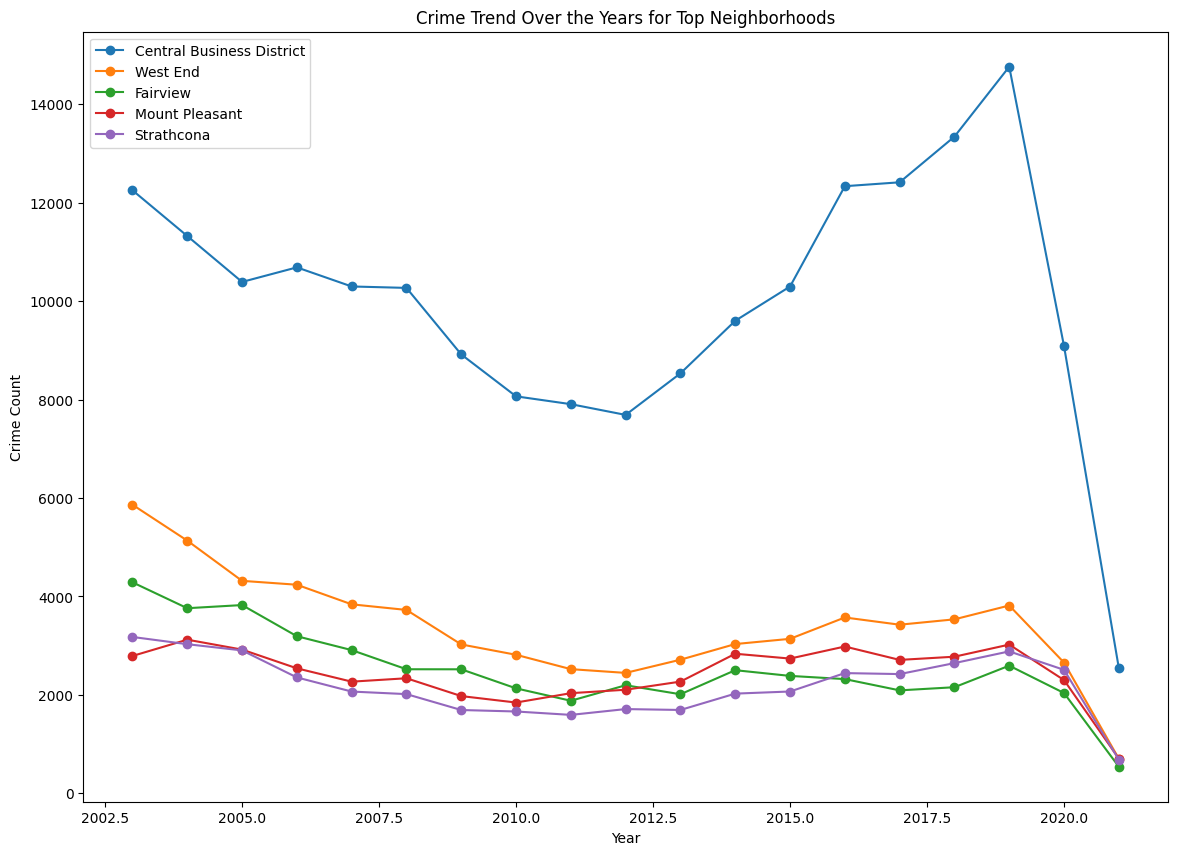

In [ ]:
# Get top 5 neighborhoods with the highest crime counts
top_neighbourhoods = crime_per_neighbourhood_pd.head(5)['NEIGHBOURHOOD']

# Filter data for top neighborhoods
top_neighbourhoods_data = crime_trend_neighbourhood.filter(F.col('NEIGHBOURHOOD').isin(top_neighbourhoods.tolist()))

# Convert to Pandas DataFrame
top_neighbourhoods_data_pd = top_neighbourhoods_data.toPandas()

# Plotting crime trends over the years for top neighborhoods
plt.figure(figsize=(14, 10))
for neighborhood in top_neighbourhoods:
    neighborhood_data = top_neighbourhoods_data_pd[top_neighbourhoods_data_pd['NEIGHBOURHOOD'] == neighborhood]
    plt.plot(neighborhood_data['YEAR'], neighborhood_data['count'], marker='o', label=neighborhood)

plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.title('Crime Trend Over the Years for Top Neighborhoods')
plt.legend()
plt.show()

+----+-----+
|HOUR|count|
+----+-----+
|   0|42772|
|   1|19475|
|   2|15362|
|   3|12923|
|   4|11510|
|   5|11010|
|   6|11847|
|   7|15971|
|   8|24117|
|   9|26013|
|  10|26281|
|  11|26942|
|  12|39088|
|  13|31069|
|  14|34324|
|  15|38252|
|  16|40828|
|  17|47223|
|  18|52255|
|  19|43476|
+----+-----+
only showing top 20 rows



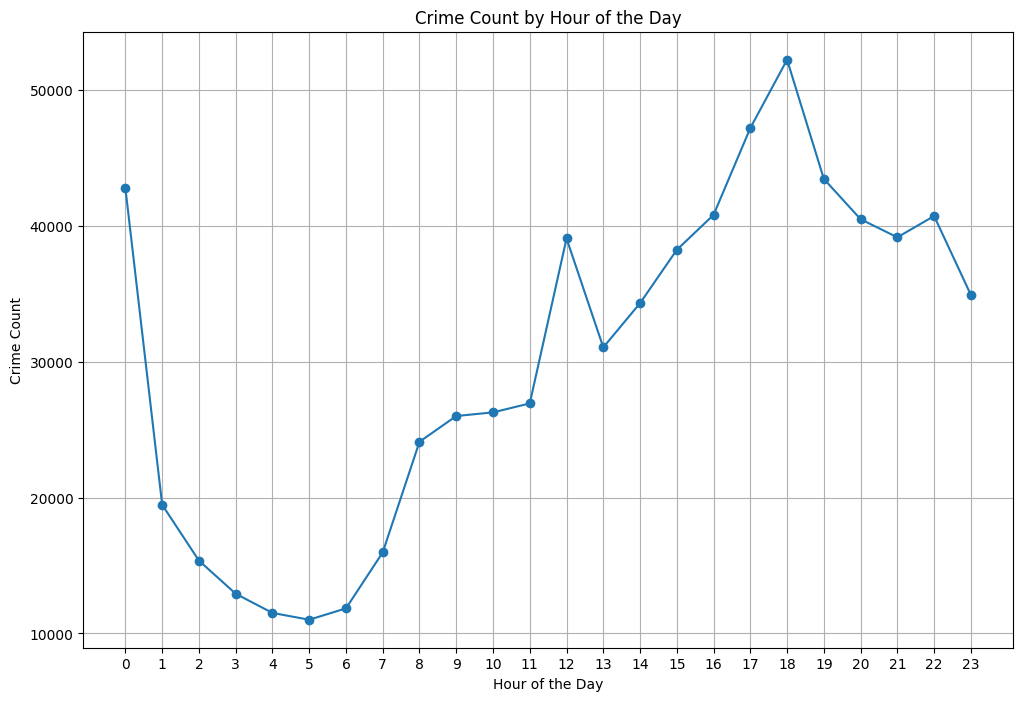

In [ ]:
# Aggregate crime count per hour
crime_per_hour = df.groupBy('HOUR').count().orderBy('HOUR')
crime_per_hour.show()

# Convert to Pandas DataFrame for visualization
crime_per_hour_pd = crime_per_hour.toPandas()

# Plotting the crime count by hour of the day
plt.figure(figsize=(12, 8))
plt.plot(crime_per_hour_pd['HOUR'], crime_per_hour_pd['count'], marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Crime Count')
plt.title('Crime Count by Hour of the Day')
plt.xticks(range(24))
plt.grid(True)
plt.show()

In [ ]:
# Identify top 3 crime types
top_3_crimes = crime_types_pd.head(3)['TYPE'].tolist()
print("Top 3 Crime Types:", top_3_crimes)

# Filter data for top 3 crime types
top3crimes_data = df.filter(F.col('TYPE').isin(top_3_crimes))


Top 3 Crime Types: ['Theft from Vehicle', 'Other Theft', 'Mischief']


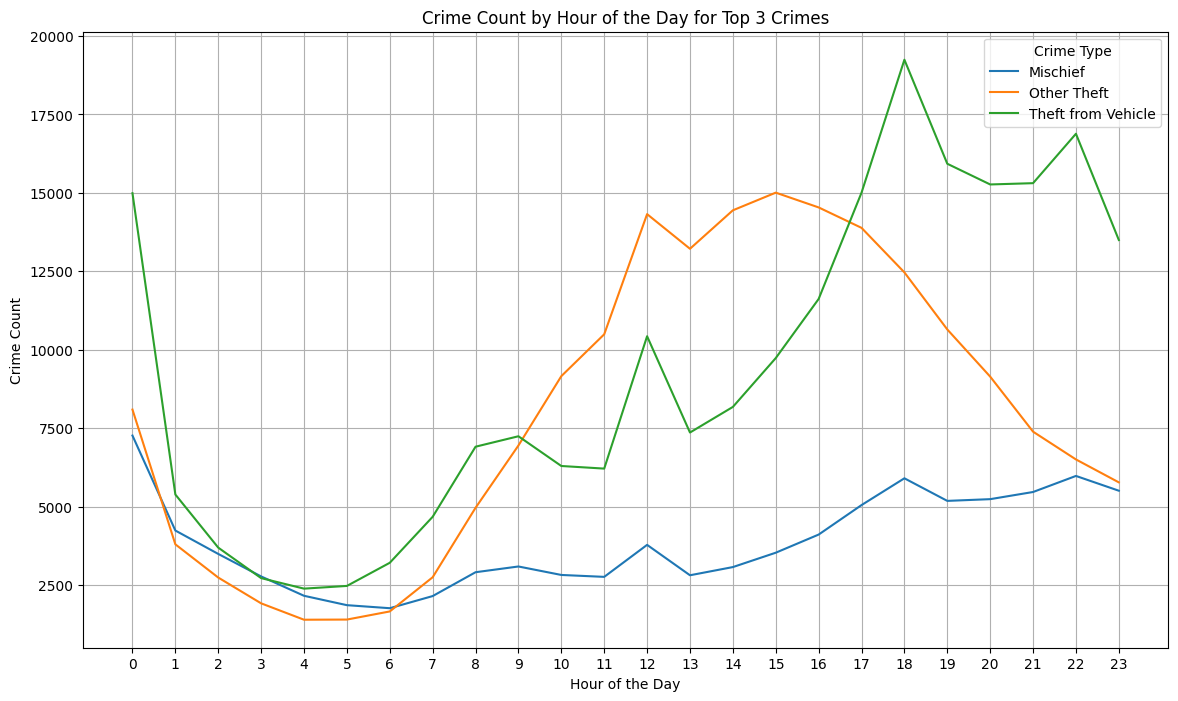

In [ ]:
# Aggregate crime count by hour and type
crime_per_hour_type = top3crimes_data.groupBy('HOUR', 'TYPE').count().orderBy('HOUR', 'TYPE')
crime_per_hour_type_pd = crime_per_hour_type.toPandas()

# Pivot the data for easier plotting
crime_per_hour_type_pivot = crime_per_hour_type_pd.pivot(index='HOUR', columns='TYPE', values='count').fillna(0)

# Plotting the crime count by hour for specific crimes
crime_per_hour_type_pivot.plot(figsize=(14, 8))
plt.xlabel('Hour of the Day')
plt.ylabel('Crime Count')
plt.title('Crime Count by Hour of the Day for Top 3 Crimes')
plt.legend(title='Crime Type')
plt.xticks(range(24))
plt.grid(True)
plt.show()


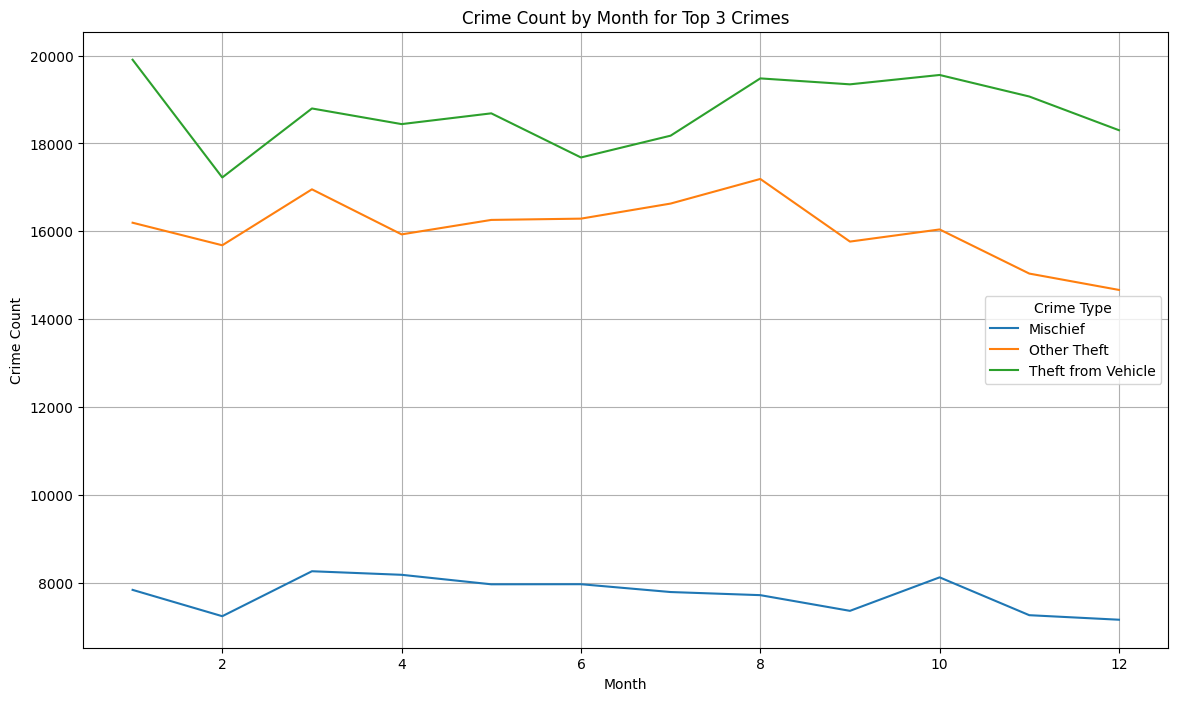

In [ ]:
#Top 3 Crimes by Month
crime_per_month_type = top3crimes_data.groupBy('MONTH', 'TYPE').count().orderBy('MONTH', 'TYPE')
crime_per_month_type_pd = crime_per_month_type.toPandas()
crime_per_month_type_pivot = crime_per_month_type_pd.pivot(index='MONTH', columns='TYPE', values='count').fillna(0)

crime_per_month_type_pivot.plot(figsize=(14, 8))
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.title('Crime Count by Month for Top 3 Crimes')
plt.legend(title='Crime Type')
plt.grid(True)
plt.show()